## Exercise 3
#### In this exercise, we will  solve a multi-class classification task with different types of Neural Networks using PyTorch.
 
### import all packages


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transformation
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random  as rnd
from sklearn.model_selection import train_test_split 
np.random.seed(208520262)  

### Visualize the Data

In [77]:
# create true labels
true_labels =  ["Airplane",  # index 0
                "Bird",      # index 1
                "Car",       # index 2 
                "Cat",       # index 3 
                "Deer",      # index 4
                "Dog",       # index 5
                "Horse",     # index 6 
                "Monkey",    # index 7 
                "Ship",      # index 8 
                "Truck"]     # index 9

# load the data that is about to be visualized.
def load_visualized_data():
    set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform = transformation.ToTensor())
    loader = torch.utils.data.DataLoader(set)
    return loader

# Visualize the data.
def visualize_data(num_images_per_label: int = 4, image_width: int = 3, image_size: int = 96) -> None:
    # Load visualized data
    loader = load_visualized_data()

    # Create subplots for each label
    fig, axes = plt.subplots(10, 1, figsize=(48, 20))
    axes = axes.flatten()

    # Initialize iterator for the data loader
    iterator = iter(loader)

    # Iterate through each label
    for index, label in enumerate(true_labels):
        example_index = 0
        class_examples_tensor = torch.empty(num_images_per_label, image_width, image_size, image_size)

        # Collect examples for the current label
        while example_index < num_images_per_label:
            example, l = next(iterator)
            if l == index:
                class_examples_tensor[example_index, :, :, :] = example
                example_index += 1
        
        # Display images for the current label
        axes[index].imshow(np.transpose(torchvision.utils.make_grid(class_examples_tensor), (1, 2, 0)))
        axes[index].set_ylabel(str(label), rotation='horizontal', fontsize=15, horizontalalignment='right')
    
    # Remove ticks from the subplots
    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.show()

# Visualize data
visualize_data()

KeyboardInterrupt: 

### Pre-processing of the data

In [ ]:
# load and preprocess the data via pytorch DataLoader 
def load_and_preprocess_data(train_batch: int = 64, test_batch: int = 64, train_size: float = 0.8, seed: int = 1, crop: int = 64, mean: tuple = (0.5, 0.5, 0.5), std: tuple = (0.5, 0.5, 0.5)) -> tuple:
    # Define transformations for training data
    train_trans = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.Normalize(mean, std),  # Normalize image data
        transformation.RandomCrop((64, 64)),  # Randomly crop image
        transformation.ColorJitter(brightness=(0,5), saturation=(0, 5), hue=(-0.5,0.5)),  # Adjust color jitter
        torchvision.transforms.RandomRotation(60)  # Randomly Rotate
    ])

    # Define transformations for testing/validation data
    test_trans = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.Normalize(mean, std),  # Normalize image data
        transformation.CenterCrop((64, 64))  # Center crop image
    ])

    # Load training, validation, and test datasets
    train_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=train_trans)
    val_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=test_trans)
    test_data = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=test_trans)

    labels = train_data.labels
    targets_idx = np.arange(len(labels))

    # Split training data into train and validation sets
    train_idx, val_idx = train_test_split(targets_idx, train_size=train_size, random_state=seed, shuffle=True, stratify=labels)

    # Create samplers for train and validation sets
    train_sample = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sample = torch.utils.data.SubsetRandomSampler(val_idx)

    # Create data loaders for train, validation, and test sets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, sampler=train_sample)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=test_batch, sampler=val_sample)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch)

    return train_loader, val_loader, test_loader

# Load training, validation, and test data
train_loader, val_loader, test_loader = load_and_preprocess_data()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Example of each augmentation

Files already downloaded and verified
Files already downloaded and verified


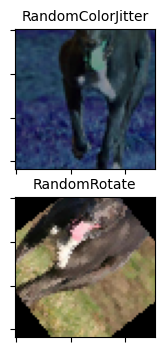

In [ ]:
def plot_augmentations(crop: int = 64) -> None:
    # Define transformation for random color jitter
    random_color_jitter = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.RandomCrop((64, 64)),  # Randomly crop image
        transformation.ColorJitter(brightness=(0,5), saturation=(0, 5), hue=(-0.5,0.5)),  # Adjust color jitter
    ])

    # Define transformation for random rotation
    random_rotation = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.RandomCrop((64, 64)),  # Randomly crop image
        transformation.RandomRotation(60)  # Randomly rotate
    ])

    # Load data with random color jitter transformation
    random_color_jitter_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=random_color_jitter)
    # Load data with random rotation transformation
    random_rotation_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=random_rotation)

    # Create data loaders
    color_jitter_loader = torch.utils.data.DataLoader(random_color_jitter_data)
    rotation_loader = torch.utils.data.DataLoader(random_rotation_data)

    # Create iterators
    color_jitter_iter = iter(color_jitter_loader)
    rotation_iter = iter(rotation_loader)

    # Create subplots for visualizing examples
    _, axes = plt.subplots(2, 1, figsize=(8, 4))
    axes = axes.flatten()

    # Retrieve examples from data loaders
    for i in range(2):
        color_jitter_example, _ = next(color_jitter_iter)
        rotation_example, _ = next(rotation_iter)

    # Display examples with titles
    axes[0].imshow(np.transpose(torchvision.utils.make_grid(color_jitter_example), (1, 2, 0)))
    axes[0].set_title('RandomColorJitter', fontsize=10)
    axes[1].imshow(np.transpose(torchvision.utils.make_grid(rotation_example), (1, 2, 0)))
    axes[1].set_title('RandomRotate', fontsize=10)

    # Remove ticks from subplots
    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()

plot_augmentations()


### 1. Logistic regression over flattened version of the images

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        # Flatten the input tensor
        self.flat = nn.Flatten(start_dim=1)
        # Fully connected layer for classification
        self.fc = nn.Linear(64 * 64 * 3, 10)

    def forward(self, x):
        # Flatten the input tensor
        x = self.flat(x)
        # Forward pass through the fully connected layer
        predictions = self.fc(x)
        return predictions

### 2. Fully-connected NN with at least 3 hidden layers over flattened version of the images followed by a classification layer.

Applied batch normalization and dropout to all hidden layers.

In [ ]:
class NN3Layers(nn.Module):
    # Constructor to define the neural network architecture
    # 64*64*3 = 12288
    def __init__(self, image_size=12288):
        super(NN3Layers, self).__init__()
        # First layer
        self.flat = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(image_size, 1500, bias=True)
        self.BN1 = nn.BatchNorm1d(1500)
        self.ReLU = nn.ReLU()
        self.D1 = nn.Dropout(p=0.5)
        # Second layer
        self.fc2 = nn.Linear(1500, 500, bias=True)
        self.BN2 = nn.BatchNorm1d(500)
        self.Tanh2 = nn.Tanh()
        self.D2 = nn.Dropout(p=0.5)
        # Third layer
        self.fc3 = nn.Linear(500, 100, bias=True)
        self.BN3 = nn.BatchNorm1d(100)
        self.Tanh3 = nn.Tanh()
        self.D3 = nn.Dropout(p=0.5)
        # Output layer
        self.fcend = nn.Linear(100, 10, bias=True) 

    # Forward pass of the neural network
    def forward(self, x):
        # Flatten the input tensor
        x = self.flat(x)                    
        # First layer
        x = self.fc1(x)
        x = self.BN1(x)
        x = self.ReLU(x)
        x = self.D1(x)
        # Second layer
        x = self.fc2(x)
        x = self.BN2(x)
        x = self.Tanh2(x)
        x = self.D2(x)
        # Third layer
        x = self.fc3(x)
        x = self.BN3(x)
        x = self.Tanh3(x)
        x = self.D3(x)
        # Output layer
        predictions = self.fcend(x)
        return predictions

### CNN with at least two convolution layers and two pooling layers followed by two fully connected layers and a classification layer.
Applied batch normalization to the convolution layers and dropout to the fully connected layers.

In [ ]:
class CNN(torch.nn.Module):
    # Constructor to define the CNN architecture
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 6, 3)
        self.BN1 = torch.nn.BatchNorm1d(6)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 10, 2)
        self.BN2 = torch.nn.BatchNorm1d(10)
        self.conv3 = torch.nn.Conv2d(10, 64, 2)
        self.BN3 = torch.nn.BatchNorm2d(64)
        # Fully connected layers
        self.fc1 = torch.nn.Linear(64 * 7 * 7, 100)
        self.D1 = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(100, 10)
        self.D2 = torch.nn.Dropout(p=0.5)
       
    # Forward pass of the CNN
    def forward(self, x):
        # Convolutional layers followed by batch normalization, activation, and pooling
        x = self.pool(F.relu(self.BN1(self.conv1(x))))
        x = self.pool(F.relu(self.BN2(self.conv2(x))))
        x = self.pool(F.relu(self.BN3(self.conv3(x))))
        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layers with dropout
        x = self.D1(F.relu(self.fc1(x)))
        predictions = self.D2(self.fc2(x))
        return predictions

### A fixed pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer.
we studied only the parameters of the task head.

In [ ]:
class Fixed_MobileNetV2(nn.Module):
    # Constructor to define the MobileNetV2 architecture
    def __init__(self):
        super(MobileNetV2, self).__init__()
        # Feature extractor using pre-trained MobileNetV2
        self.feature_extractor = models.mobilenet_v2(pretrained=True)
        # Freeze feature extractor parameters
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        # Modify classifier to adjust for new output classes
        self.feature_extractor.classifier[1] = nn.Linear(self.feature_extractor.classifier[1].in_features, out_features=200)
        # Dropout layers
        self.d1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(200, 20) 
        self.d2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(20, 10) 
        self.d3 = nn.Dropout(p=0.4) 
        
    # Forward pass of MobileNetV2
    def forward(self, x):
        # Feature extraction
        x = self.feature_extractor(x)
        # Dropout and activation
        x = self.d1(F.relu(x)) 
        # Second fully connected layer with dropout and activation
        x = self.d2(F.relu(self.fc2(x)))
        # Final fully connected layer with dropout
        predictions = self.d3(self.fc3(x))
        return predictions

### . A learned pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer.
we studied the parameters of the MobileNetV2 as well.

In [ ]:
class Learned_MobileNetV2(nn.Module):
    # Constructor to define the Learned_MobileNetV2 architecture
    def __init__(self):
        super(Learned_MobileNetV2, self).__init__()
        # Feature extractor using pre-trained MobileNetV2
        self.feature_extractor = models.mobilenet_v2(pretrained=True) 
        # Modify classifier to adjust for new output classes
        self.feature_extractor.classifier[1] = nn.Linear(self.feature_extractor.classifier[1].in_features, out_features=200)
        # Dropout layers
        self.d1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(200, 20) 
        self.d2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(20, 10) 
        self.d3 = nn.Dropout(p=0.2) 
        
    # Forward pass of Learned_MobileNetV2
    def forward(self, x):
        # Feature extraction
        x = self.feature_extractor(x)
        # Dropout and activation
        x = self.d1(F.relu(x)) 
        # Second fully connected layer with dropout and activation
        x = self.d2(F.relu(self.fc2(x)))
        # Final fully connected layer with dropout
        predictions = self.d3(self.fc3(x))
        return predictions

### testing function for the test data on a trained model

In [ ]:
def test(test_loader, model, device):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to store test metrics
    test_loss = 0
    correct = 0
    num_batch = 0
    criterion = nn.CrossEntropyLoss()
    total = 0
    
    # Disable gradient calculation during testing
    with torch.no_grad():
        # Iterate over test data batches
        for images, labels in test_loader:
            num_batch += 1
            # Move data and labels to the appropriate device
            images, labels= images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # Calculate the number of correct predictions
            correct += (predicted == labels).sum().item()
            # Calculate the loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # Calculate accuracy and average loss
    accuracy = correct / total
    loss = test_loss / num_batch

    return accuracy, loss

### training a model and validating it using the test function

In [ ]:
def train(train_loader, val_loader, model, device, hyper_parameters):
    # Extract hyperparameters
    epochs, lr, momentum, weight_decay, optimizer_type = hyper_parameters
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Choose optimizer based on specified optimizer type
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    elif optimizer_type == 'RMSProp':
        optimizer = optim.RMSProp(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=weight_decay)
    else:
        raise NotImplementedError("Optimizer not implemented")
    
    # Lists to store training and validation metrics
    train_losses, train_accuracy, val_losses, val_accuracy = ([] for i in range(4))
    
    # Loop through epochs
    for epoch in range(1, epochs + 1):
        model.train()  # Set the model to training mode
        cumm_loss = 0
        num_batch = 0
        train_cor = 0.
        train_tot = 0.

        # Iterate over training data batches
        for (data, target) in train_loader:
            num_batch += 1

            # Move data and target to the appropriate device (GPU if available)
            data, target = data.to(device), target.to(device)

            # Reset gradients to zero
            optimizer.zero_grad()

            # Forward pass
            logits = model(data)

            # Compute loss
            loss = criterion(logits, target)

            # Backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            # Update training metrics
            cumm_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_tot += target.size(0)
            train_cor += (predicted == target).sum().item()

        # Calculate and store training loss and accuracy
        train_losses.append(cumm_loss / num_batch)
        train_accuracy.append(train_cor / train_tot)

        # Evaluate on validation set
        curr_val_accuracy, curr_val_loss = test(val_loader, model, device)
        val_accuracy.append(curr_val_accuracy)
        val_losses.append(curr_val_loss)

        # Print epoch-wise training and validation metrics
        print('epoch %d \tloss: %.3f\t  acc:%.3f\t val_acc:%.3f' %
              (epoch, cumm_loss / num_batch, train_cor / train_tot, curr_val_accuracy))

    # Store the results
    results = train_accuracy, train_losses, val_accuracy, val_losses

    return model, results

### Plot loss

In [ ]:
def plot_loss(results, epochs, lr, momentum, weight_decay, model_type):
    # Extract results
    train_accuracy, train_losses, val_accuracy, val_losses = results
    
    # Create array of epochs
    steps = np.arange(epochs)
    
    # Create subplots
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # Plot training and validation loss
    ax1.plot(steps, train_losses, label="Train Loss", color='red')
    ax1.plot(steps, val_losses, label="Validation Loss", color='green')
    
    # Create second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')
    
    # Plot training and validation accuracy
    ax2.plot(steps, train_accuracy, label="Train Accuracy", color='black')
    ax2.plot(steps, val_accuracy, label="Validation Accuracy", color='blue')
    
    # Set title
    plt.suptitle(model_type, fontsize=16)
    plt.title('Epochs={}, Learning Rate={}, Momentum={}, Weight Decay={}'.format(epochs, lr, momentum, weight_decay), fontsize=10)
    
    # Add legend
    fig.legend()
    fig.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print mean training accuracy
    print("Train accuracy is: " + str(np.mean(train_accuracy)))

### Define parameters
At first, we ested different configurations of hyperparameters: layer size, optimizer, batch size, learning rate, regularization coefficient, etc.
The parameters we tested are in the note next to the final parameters that turned out to be the best (and for which we drew the graph as requested in the task).

In [ ]:
# Define hyperparameters
#epochs = [150, 200, 100]
#lr = [0.00005, 0.01, 0.0001, 0.00015] 
#optim = ['SGD', 'Adam', 'RMSProp']
#l2_reg = [0.01, 0.01, 0.0001, 0.00005, 4e-05] 
#momentu = [0.2, 0.25, 0, 0.9, 0.01] 
#batch_size = [64, 128, 256, 512]  
#test_batch_size = [64, 128, 256, 512] 
# weight_decay = [1e-4, 1e-5]    

batch_size = 64  # Batch size for training
test_batch_size = 64  # Batch size for testing
epochs = 100  # Number of epochs
lr = 0.01  # Learning rate
cuda = False  # Whether to use CUDA (GPU)
seed = 208520262  # Random seed
optimizer_type = 'SGD'  # Type of optimizer to use (SGD, Adam, RMSprop)
momentum = 0.01  # Momentum for SGD optimizer
weight_decay = 1e-4  # Weight decay for regularization
validation_part = 0.2  # Percentage of validation data split

### Running the networks

In [ ]:
# Check if CUDA is available and if it should be used
use_cuda = cuda and torch.cuda.is_available()

# Set seed for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Handle GPU stochasticity
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Determine device (CPU or GPU)
device = torch.device("cuda" if use_cuda else "cpu")

# Define hyperparameters
hyper_parameters = epochs, lr, momentum, weight_decay, optimizer_type

# Load data
train_loader, val_loader, test_loader = load_data(batch_size, test_batch_size, validation_part, seed)

# Model selection
#model = LogisticRegression().to(device)  # Choose model here
# model = NN3Layers().to(device)
# model = CNN().to(device)
# model = Fixed_MobileNetV2().to(device)  
# model = Learned_MobileNetV2().to(device)

# Run the model
model, results = train(train_loader, val_loader, model, device, hyper_parameters)
test_acc, _ = test(test_loader, model, device)
print("Test accuracy:", test_acc)

# Plot loss and accuracy
plot_loss(results, epochs, lr, momentum, weight_decay, "Model_Name")